In [93]:
from __future__ import absolute_import
from sage.graphs.connectivity import TriconnectivitySPQR
from sage.graphs.connectivity import spqr_tree_to_graph
from sage.graphs.graph_latex import check_tkz_graph
from sage.graphs.graph import Graph
from sage.rings.integer import Integer

In [94]:
from operator import itemgetter
import pandas as pd
import itertools
import os
import networkx as nx
from networkx.drawing.nx_pydot import to_pydot
from graphviz import Source
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [95]:
class recorridoDepth:

	def __init__(self, G, s):
		self.G = G
		self.s = s
		self.tree = nx.DiGraph()
		self.e_t = set()
		self.e_b = set()
		self.n = 0
		self.lowpt1 = {b:0  for b in G.keys()}
		self.lowpt2 = {b:0  for b in G.keys()}
		self.ln = {b:0  for b in G.keys()}
		self.nD = {b:0  for b in G.keys()}
		self.father = {b:0  for b in G.keys()}
		self.ln[1] = 1
		self.father[1] = None
		self.flag = {b:True  for b in G.keys()}
		self.G2 = nx.DiGraph()
		self.G1 = nx.DiGraph()
		self.m = len(G.keys())
		self.descendientes = {b:set()  for b in G.keys()}

	def d_f(self, v, u=0):
		self.n = self.n + 1
		self.lowpt1[v] = self.lowpt2[v] = self.ln[v] = self.n
		self.nD[v] = 1
		for w in self.G[v]:
			e2 = (v, w)
			if self.ln[w] == 0:
				self.e_t.add(e2)
				self.d_f(w, v)
				self.adjust_lowpt1(v, w)
				self.father[w] = v
				self.nD[v] = self.nD[v] + self.nD[w]
			elif (self.ln[w] < self.ln[v]) and ((w != u) or (not self.flag[v])):
				self.e_b.add(e2)
				self.adjust_lowpt2(v, w)
			if w == u:
				self.flag[v] = False
		self.G1.add_edges_from(list(self.e_t), color='red', style='dashed')
		self.G2.add_edges_from(list(self.e_b), color='blue')

	def adjust_lowpt1(self, v, w):
		if self.lowpt1[w] < self.lowpt1[v]:
			self.lowpt2[v] = min(self.lowpt1[v], self.lowpt2[w])
			self.lowpt1[v] = self.lowpt1[w]
		elif self.lowpt1[w] == self.lowpt1[v]:
			self.lowpt2[v] = min(self.lowpt2[v], self.lowpt2[w])
		else:
			self.lowpt2[v] = min(self.lowpt2[v], self.lowpt1[w])
		return self.lowpt1, self.lowpt2

	def adjust_lowpt2(self, v, w):
		if self.ln[w] < self.lowpt1[v]:
			self.lowpt2[v] = self.lowpt1[v]
			self.lowpt1[v] = self.ln[w]
		elif self.ln[w] > self.lowpt1[v]:
			self.lowpt2[v] = min(self.lowpt2[v], self.ln[w])
		return self.lowpt1, self.lowpt2

	def dFS(self):
		self.d_f(self.s, u=0)
		return sorted(self.e_t, key=itemgetter(0,1)), sorted(self.e_b, key=itemgetter(0,1))

	def dibujar_grafo_recorrido(self, file):

		self.tree = self.depthTree()

		colors = nx.get_edge_attributes(self.tree,'color').values()
		dot = to_pydot(self.tree).to_string()
		#print(dot)

		src = Source(dot) # dot is string containing DOT notation of graph
		#src.view()

		name, ext = os.path.splitext(file)
		graph = Source(dot)
		graph.format = ext[1:]
		graph.render(name, cleanup=True)
		return graph

	def depthTree(self):
		X = range(1, len(list(self.G.values()))+1)
		self.G1.add_edges_from(list(self.e_t), color='red', style='dashed')
		self.G2.add_edges_from(list(self.e_b), color='blue')
		self.tree = nx.compose(self.G1, self.G2)
		self.tree.add_nodes_from(X)
		return self.tree

	#def lowpt(self):
	#    return self.lowpt1, self.lowpt2

	def fathers(self):
		return self.father

	def low1_low2(self):
		df = pd.DataFrame(list(self.lowpt1.items()),
						  columns=['vertice', 'lowpt1'])
		df['lowpt2'] = self.lowpt2.values()
		return df

	def descendants(self):
		for i in self.G1.nodes():
			self.descendientes[i] = nx.descendants(self.G1, i)
		return self.descendientes

In [96]:
class auxTricconected(recorridoDepth):

	def __init__(self, G, s):
		recorridoDepth.__init__(self, G, s)
		self.Spanning_Tree, self.Bactracking_Tree  = self.dFS()
		self.path = []
		self.i = 1
		self.paths = []

	def etiquetado(self):
		edge = list((a, b) for (a, b) in self.G1.edges())
		edges = list((a, b) for (a, b) in self.G2.edges())
		s_t = {(a, b):0 for (a, b) in edge}
		b_t = {(a, b):0 for (a, b) in edges}
		for u, v in s_t.copy().items():
			if self.lowpt2[u[1]] < u[0]:
				s_t[u] = 3*self.lowpt1[u[1]]
			if self.lowpt2[u[1]] >= u[0]:
				s_t[u] = 3*self.lowpt1[u[1]] + 2
		for u, v in b_t.copy().items():
			b_t[u] = 3*u[1] + 1
		return s_t, b_t

	def ordenado(self):
		o_t, o_b = self.etiquetado()
		o_a = {**o_t, **o_b}
		d_o = dict(sorted(o_a.items(), key=itemgetter(1)))
		return list(d_o.keys())

	def ordenamientoDic(self):
		aristas_ordenadas = self.ordenado()
		dicc = {}
		for sublista in aristas_ordenadas:
			key = sublista[0]
			value = sublista[1]
			if key not in dicc:
				dicc[key] = []
			dicc[key].append(value)
		valores_ord = dict(sorted(dicc.items()))
		return valores_ord

	def pathfinder(self, u):
		ordDic = self.ordenamientoDic()
		for v in ordDic[u]:
			if (u, v) in self.e_t:
				self.path.append((u, v))
				self.pathfinder(v)
			if (u, v) in self.e_b:
				self.path.append((u,v))
				self.paths.append({self.i:self.path})
				print("path: ", self.path)
				self.i+=1
			self.path=[]
		return self.paths

In [97]:
class _LinkedListNode:
	"""
	Node in a ``_LinkedList``.

	This class implements a node of a (doubly) linked list and so has pointers
	to previous and next nodes in the list.
	"""
	def __init__(self, data=None):
		"""
		Initialize this ``_LinkedListNode``.

		INPUT:

		- ``data`` -- (default: ``None``) either an edge, or an integer.
		"""
		self.prev = None
		self.next = None
		self.set_data(data)

	def set_data(self, data):
		self.data = data

	def get_data(self):
		return self.data

In [98]:
class _LinkedList:
	"""
	A doubly linked list with head and tail pointers.

	This is a helper class for ``TriconnectivitySPQR``.

	This class implements a doubly linked list of ``_LinkedListNode``.
	"""
	def __init__(self):
		"""
		Initialize this ``_LinkedList``.
		"""
		self.head = None
		self.tail = None
		self.length = 0

	def remove(self, node):
		"""
		Remove the node ``node`` from the linked list.
		"""
		if node.prev is None and node.next is None:
			self.head = None
			self.tail = None
		elif node.prev is None: # node is head
			self.head = node.next
			node.next.prev = None
		elif node.next is None: #node is tail
			node.prev.next = None
			self.tail = node.prev
		else:
			node.prev.next = node.next
			node.next.prev = node.prev
		self.length -= 1

	def set_head(self, h):
		"""
		Set the node ``h`` as the head of the linked list.
		"""
		self.head = h
		self.tail = h
		self.length = 1

	def append(self, node):
		"""
		Append the node ``node`` to the linked list.
		"""
		if self.head is None:
			self.set_head(node)
		else:
			self.tail.next = node
			node.prev = self.tail
			self.tail = node
			self.length += 1

	def get_head(self):
		return self.head

	def get_length(self):
		return self.length

	def push_front(self, node):
		"""
		Add node ``node`` to the beginning of the linked list.
		"""
		if self.head is None:
			self.set_head(node)
		else:
			self.head.prev = node
			node.next = self.head
			self.head = node
			self.length += 1

	def to_string(self):
		"""
		Return a string representation of self.
		"""
		temp = self.head
		s = ""
		while temp:
			s += "  " + str(temp.get_data())
			temp = temp.next
		return s

	def concatenate(self, lst2):
		"""
		Concatenate lst2 to self.

		Makes lst2 empty.
		"""
		self.tail.next = lst2.head
		lst2.head.prev = self.tail
		self.tail = lst2.tail
		self.length += lst2.length
		lst2.head = None
		lst2.length = 0

In [99]:
class _Component:
	"""
	Connected component class.

	This is a helper class for ``TriconnectivitySPQR``.

	This class is used to store a connected component. It contains:
	- ``edge_list`` -- list of edges belonging to the component, stored as a
	  ``_LinkedList``.

	- ``component_type`` -- the type of the component.
		- 0 if bond.
		- 1 if polygon.
		- 2 is triconnected component.
	"""
	def __init__(self, edge_list, type_c):
		"""
		Initialize this component.

		INPUT:

		- ``edge_list`` -- list of edges to be added to the component.

		- `type_c` -- type of the component (0, 1, or 2).
		"""
		self.edge_list = _LinkedList()
		for e in edge_list:
			self.add_edge(e)
		self.component_type = type_c

	def add_edge(self, e):
		self.edge_list.append(_LinkedListNode(e))

	def finish_tric_or_poly(self, e):
		r"""
		Finalize the component by adding edge `e`.

		Edge `e` is the last edge to be added to the component.
		Classify the component as a polygon or triconnected component
		depending on the number of edges belonging to it.
		"""
		self.add_edge(e)
		if self.edge_list.get_length() > 3:
			self.component_type = 2
		else:
			self.component_type = 1

	def __str__(self):
		"""
		Return a string representation of the component.
		"""
		if self.component_type == 0:
			type_str = "Bond: "
		elif self.component_type == 1:
			type_str =  "Polygon: "
		else:
			type_str = "Triconnected: "
		return type_str + self.edge_list.to_string()

	def get_edge_list(self):
		"""
		Return the list of edges belonging to the component.
		"""
		e_list = []
		e_node = self.edge_list.get_head()
		while e_node:
			e_list.append(e_node.get_data())
			e_node = e_node.next
		return e_list

In [100]:
class TriconnectivitySPQR_Aux:
	r"""
	Decompose a graph into triconnected components and build SPQR-tree.

	This class implements the algorithm proposed by Hopcroft and Tarjan in
	[Hopcroft1973]_, and later corrected by Gutwenger and Mutzel in [Gut2001]_,
	for finding the triconnected components of a biconnected graph. It then
	organizes these components into a SPQR-tree. See the:wikipedia:`SPQR_tree`.

	A SPQR-tree is a tree data structure used to represent the triconnected
	components of a biconnected (multi)graph and the 2-vertex cuts separating
	them. A node of a SPQR-tree, and the graph associated with it, can be one of
	the following four types:

	- ``"S"`` -- the associated graph is a cycle with at least three vertices.
	  ``"S"`` stands for ``series`` and is also called a ``polygon``.

	- ``"P"`` -- the associated graph is a dipole graph, a multigraph with two
	  vertices and three or more edges. ``"P"`` stands for ``parallel`` and the
	  node is called a ``bond``.

	- ``"Q"`` -- the associated graph has a single real edge. This trivial case
	  is necessary to handle the graph that has only one edge.

	- ``"R"`` -- the associated graph is a 3-vertex-connected graph that is not
	  a cycle or dipole. ``"R"`` stands for ``rigid``.

	The edges of the tree indicate the 2-vertex cuts of the graph.

	INPUT:

	- ``G`` -- the input graph. If ``G`` is a DiGraph, the computation is done
	  on the underlying Graph (i.e., ignoring edge orientation).

	- ``check`` -- boolean (default: ``True``); indicates whether ``G`` needs to
	  be tested for biconnectivity.

	An example from [Hopcroft1973]_::

		sage: G = Graph([(1, 2), (1, 4), (1, 8), (1, 12), (1, 13), (2, 3),
		....: (2, 13), (3, 4), (3, 13), (4, 5), (4, 7), (5, 6), (5, 7), (5, 8),
		....: (6, 7), (8, 9), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12),
		....: (10, 11), (10, 12)])
		sage: tric = TriconnectivitySPQR(G)
		sage: tric.print_triconnected_components()
		Triconnected:  [(8, 9, None), (9, 10, None), (10, 11, None), (9, 11, None), (8, 11, None), (10, 12, None), (9, 12, None), (8, 12, 'newVEdge0')]
		Bond:  [(8, 12, None), (8, 12, 'newVEdge0'), (8, 12, 'newVEdge1')]
		Polygon:  [(8, 12, 'newVEdge1'), (1, 12, None), (8, 1, 'newVEdge2')]
		Bond:  [(1, 8, None), (8, 1, 'newVEdge2'), (8, 1, 'newVEdge3')]
		Polygon:  [(5, 8, None), (8, 1, 'newVEdge3'), (4, 5, 'newVEdge8'), (4, 1, 'newVEdge9')]
		Polygon:  [(5, 6, None), (6, 7, None), (5, 7, 'newVEdge5')]
		Bond:  [(5, 7, None), (5, 7, 'newVEdge5'), (5, 7, 'newVEdge6')]
		Polygon:  [(5, 7, 'newVEdge6'), (4, 7, None), (5, 4, 'newVEdge7')]
		Bond:  [(5, 4, 'newVEdge7'), (4, 5, 'newVEdge8'), (4, 5, None)]
		Bond:  [(1, 4, None), (4, 1, 'newVEdge9'), (4, 1, 'newVEdge10')]
		Polygon:  [(3, 4, None), (4, 1, 'newVEdge10'), (3, 1, 'newVEdge11')]
		Triconnected:  [(1, 13, None), (2, 13, None), (3, 13, None), (3, 1, 'newVEdge11'), (2, 3, None), (1, 2, None)]
	"""
	def __init__(self, G, check=True):
		"""
		Initialize this object, decompose the graph and build SPQR-tree.

		INPUT:

		- ``G`` -- the input graph. If ``G`` is a DiGraph, the computation is
		  done on the underlying Graph (i.e., ignoring edge orientation).

		- ``check`` -- boolean (default: ``True``); indicates whether ``G``
		  needs to be tested for biconnectivity.
		"""
		self.n = G.order()
		self.m = G.size()
		self.graph_name = G.name()

		# Trivial cases
		if self.n < 2:
			raise ValueError("Graph is not biconnected")
		elif self.n == 2 and self.m:
			# a P block with at least 1 edge
			self.comp_list_new = [G.edges()]
			self.comp_type = [0]
			self.__build_spqr_tree()
			return
		elif self.m < self.n -1:
			# less edges than a tree
			raise ValueError("Graph is not connected")
		elif self.m < self.n:
			# less edges than a cycle
			raise ValueError("Graph is not biconnected")

		from sage.graphs.graph import Graph

		# Make a copy of the input graph G in which
		# - vertices are relabeled as integers in [0..n-1]
		# - edges are relabeled with distinct labels in order to distinguish
		#   between multi-edges
		self.int_to_vertex = G.vertices()
		self.vertex_to_int = {u:i for i,u in enumerate(self.int_to_vertex)}
		self.int_to_original_edge_label = [] # to associate original edge label
		self.graph_copy = Graph(self.n, multiedges=True)
		for i,(u, v, l) in enumerate(G.edge_iterator()):
			self.graph_copy.add_edge(self.vertex_to_int[u], self.vertex_to_int[v], i)
			self.int_to_original_edge_label.append(l)

		#
		# Initialize data structures needed for the algorithm
		#

		# status of each edge: unseen=0, tree=1, frond=2
		self.edge_status = {e: 0 for e in self.graph_copy.edge_iterator()}

		# Edges of the graph which are in the reverse direction in palm tree
		self.reverse_edges = set()

		self.dfs_number = [0 for i in range(self.n+1)] # DFS number of vertex i

		# Linked list of fronds entering vertex i in the order they are visited
		self.highpt = [_LinkedList() for i in range(self.n)]

		# A dictionary whose key is an edge e, value is a pointer to element in
		# self.highpt containing the edge e. Used in the `path_search` function.
		self.in_high = {e:None for e in self.graph_copy.edge_iterator()}

		# Translates DFS number of a vertex to its new number
		self.old_to_new = [0 for i in range(self.n+1)]
		self.newnum = [0 for i in range(self.n)] # new number of vertex i
		self.node_at = [0 for i in range(self.n+1)] # node at dfs number of i
		self.lowpt1 = [None for i in range(self.n)] # lowpt1 number of vertex i
		self.lowpt2 = [None for i in range(self.n)] # lowpt2 number of vertex i

		# i^th value contains a LinkedList of incident edges of vertex i
		self.adj = [_LinkedList() for i in range(self.n)]

		# A dictionary whose key is an edge, value is a pointer to element in
		# self.adj containing the edge. Used in the `path_search` function.
		self.in_adj = {}
		self.nd = [None for i in range(self.n)] # number of descendants of vertex i

		# Parent vertex of vertex i in the palm tree
		self.parent = [None for i in range(self.n)]
		self.degree = [None for i in range(self.n)] # Degree of vertex i
		self.tree_arc = [None for i in range(self.n)] # Tree arc entering the vertex i
		self.vertex_at = [1 for i in range(self.n)] # vertex with DFS number of i
		self.dfs_counter = 0
		self.components_list = [] # list of components of `graph_copy`
		self.graph_copy_adjacency = [[] for i in range(self.n)] # Stores adjacency list

		# Dictionary of (e, True/False) to denote if edge e starts a path
		self.starts_path = {e:False for e in self.graph_copy.edge_iterator()}

		self.is_biconnected = True # Boolean to store if the graph is biconnected or not
		self.cut_vertex = None # If graph is not biconnected

		# Label used for virtual edges, incremented at every new virtual edge
		self.virtual_edge_num = 0
		# Virtual edges are stored in a set
		self.virtual_edges = set()

		self.new_path = False # Boolean used to store if new path is started

		# Stacks used in `path_search` function
		self.e_stack = []
		self.t_stack_h = [None for i in range(2*self.m + 1)]
		self.t_stack_a = [None for i in range(2*self.m + 1)]
		self.t_stack_b = [None for i in range(2*self.m + 1)]
		self.t_stack_top = 0
		self.t_stack_a[self.t_stack_top] = -1

		# The final triconnected components are stored
		self.comp_list_new = [] # i^th entry is list of edges in i^th component
		self.comp_type = [] # i^th entry is type of i^th component
		# The final SPQR tree is stored
		self.spqr_tree = None # Graph

		self.type1 = []
		self.type2 = []
		#
		# Triconnectivity algorithm
		#

		# Deal with multiple edges
		self.__split_multiple_edges()

		# Build adjacency list
		for e in self.graph_copy.edge_iterator():
			self.graph_copy_adjacency[e[0]].append(e)
			self.graph_copy_adjacency[e[1]].append(e)

		self.dfs_counter = 0 # Initialisation for dfs1()
		self.start_vertex = 0 # Initialisation for dfs1()
		self.cut_vertex = self.__dfs1(self.start_vertex, check=check)

		if check:
			# If graph is disconnected
			if self.dfs_counter < self.n:
				raise ValueError("Graph is not connected")

			# If graph has a cut vertex
			if self.cut_vertex != None:
				raise ValueError("Graph has a cut vertex")

		# Identify reversed edges to reflect the palm tree arcs and fronds
		for e in self.graph_copy.edge_iterator():
			up = (self.dfs_number[e[1]] - self.dfs_number[e[0]]) > 0
			if (up and self.edge_status[e]==2) or (not up and self.edge_status[e]==1):
				# Add edge to the set reverse_edges
				self.reverse_edges.add(e)

		self.__build_acceptable_adj_struct()
		self.__dfs2()

		self.__path_search(self.start_vertex)

		# last split component
		if self.e_stack:
			e = self.__estack_pop()
			c = _Component(self.e_stack, 0)
			c.finish_tric_or_poly(e)
			self.components_list.append(c)

		self.__print_split()
		self.__assemble_triconnected_components()

		self.__build_spqr_tree()

	def __tstack_push(self, h, a, b):
		"""
		Push ``(h, a, b)`` triple on Tstack
		"""
		self.t_stack_top += 1
		self.t_stack_h[self.t_stack_top] = h
		self.t_stack_a[self.t_stack_top] = a
		self.t_stack_b[self.t_stack_top] = b

	def __tstack_push_eos(self):
		"""
		Push end-of-stack marker on Tstack
		"""
		self.t_stack_top += 1
		self.t_stack_a[self.t_stack_top] = -1

	def __tstack_not_eos(self):
		"""
		Return true iff end-of-stack marker is not on top of Tstack
		"""
		return self.t_stack_a[self.t_stack_top] != -1

	def __tstack_print(self):
		"""
		Return true iff end-of-stack marker is not on top of Tstack
		"""
		return self.t_stack_a, self.t_stack_b, self.t_stack_h

	def __estack_pop(self):
		"""
		Pop from estack and return the popped element
		"""
		return self.e_stack.pop()

	def __estack_print(self):
		"""
		Pop from estack and return the popped element
		"""
		return self.e_stack

	def __new_component(self, edges=[], type_c=0):
		"""
		Create a new component and add `edges` to it.
		type_c = 0 for bond, 1 for polygon, 2 for triconnected component
		"""
		c = _Component(edges, type_c)
		self.components_list.append(c)
		return c

	def __new_virtual_edge(self, u, v):
		"""
		Return a new virtual edge between `u` and `v`.
		"""
		e = (u, v, "newVEdge"+str(self.virtual_edge_num))
		self.virtual_edge_num += 1
		self.virtual_edges.add(e)
		return e

	def __high(self, v):
		"""
		Return the high(v) value, which is the first value in highpt list of v.
		"""
		head = self.highpt[v].get_head()
		if head is None:
			return 0
		else:
			return head.get_data()

	def __del_high(self, e):
		"""
		Delete edge e from the highpt list of the endpoint v it belongs to.
		"""
		if e in self.in_high:
			it = self.in_high[e]
			if it:
				if e in self.reverse_edges:
					v = e[0]
				else:
					v = e[1]
				self.highpt[v].remove(it)

	def __bucket_sort(self, bucket, edge_list):
		"""
		Use radix sort to sort the buckets
		"""
		# if only one edge is present
		if len(bucket) == 1:
			return

		# Create n bucket linked lists
		bucket_list = []
		for i in range(self.n):
			bucket_list.append(_LinkedList())

		# Get the head pointer of the edge list
		e_node = edge_list.head

		# Link the n buckets w.r.t bucketId
		while e_node:
			bucketId = bucket[e_node.get_data()]
			if bucket_list[bucketId].get_head():
				bucket_list[bucketId].tail.next = e_node
				bucket_list[bucketId].tail = bucket_list[bucketId].tail.next
			else:
				bucket_list[bucketId].set_head(e_node)
			e_node = e_node.next

		# Rearrange the `edge_list` Using bucket list
		new_tail = None
		for i in range(self.n):
			new_head = bucket_list[i].get_head()
			if new_head:
				if new_tail:
					new_tail.next = new_head
				else:
					edge_list.set_head(new_head)
				new_tail = bucket_list[i].tail

		edge_list.tail = new_tail
		new_tail.next = None

	def __sort_edges(self):
		"""
		A helper function for `split_multiple_edges` to sort the edges of
		graph_copy.

		Sorts the edges of `graph_copy` and stores the sorted edges in a linked
		list. The head pointer of the linked list is returned.

		This function is an implementation of the sorting algorithm given in
		[Hopcroft1973]_.
		"""
		# Create a linkedlist of edges
		edge_list = _LinkedList()
		for e in self.graph_copy.edges(sort=False):
			edge_list.append(_LinkedListNode(e))

		bucketMin = {} # Contains the lower index of edge end point
		bucketMax = {} # Contains the higher index of edge end point

		# In `graph_copy`, every edge `(u, v)` is such that `u < v`.
		# Hence, `bucketMin` of an edge `(u, v)` will be `u`
		# and `bucketMax` will be `v`.
		for e in self.graph_copy.edge_iterator():
			bucketMin[e] = e[0]
			bucketMax[e] = e[1]

		# Sort according to the endpoint with lower index
		self.__bucket_sort(bucketMin, edge_list)
		# Sort according to the endpoint with higher index
		self.__bucket_sort(bucketMax, edge_list)

		# Return the head pointer to the sorted edge list
		return edge_list.get_head()

	def __split_multiple_edges(self):
		"""
		Make the graph simple and build bonds recording multiple edges.

		If there are `k` multiple edges between `u` and `v`, then a new
		component (a bond) with `k+1` edges (one of them is a virtual edge) will
		be created, all the `k` edges are deleted from the graph and the virtual
		edge between `u` and `v` is added to the graph.
		"""
		comp = []
		if self.graph_copy.has_multiple_edges():
			sorted_edges = self.__sort_edges()
			while sorted_edges.next:
				# Find multi edges and add to component and delete from graph
				if (sorted_edges.get_data()[0] == sorted_edges.next.get_data()[0]) and (sorted_edges.get_data()[1] == sorted_edges.next.get_data()[1]):
					self.graph_copy.delete_edge(sorted_edges.get_data())
					comp.append(sorted_edges.get_data())
				else:
					if comp:
						comp.append(sorted_edges.get_data())
						self.graph_copy.delete_edge(sorted_edges.get_data())

						# Add virtual edge to graph_copy
						newVEdge = self.__new_virtual_edge(sorted_edges.get_data()[0],
														   sorted_edges.get_data()[1])
						self.graph_copy.add_edge(newVEdge)

						# mark unseen for newVEdge
						self.edge_status[newVEdge] = 0

						comp.append(newVEdge)
						self.__new_component(comp)
					comp = []
				sorted_edges = sorted_edges.next
			if comp:
				comp.append(sorted_edges.get_data())
				self.graph_copy.delete_edge(sorted_edges.get_data())

				# Add virtual edge to graph_copy
				newVEdge = self.__new_virtual_edge(sorted_edges.get_data()[0], sorted_edges.get_data()[1])
				self.graph_copy.add_edge(newVEdge)
				self.edge_status[newVEdge] = 0

				comp.append(newVEdge)
				self.__new_component(comp)

	def __dfs1(self, v, u=None, check=True):
		"""
		This function builds the palm-tree of the graph using a dfs traversal.

		Also populates the lists ``lowpt1``, ``lowpt2``, ``nd``, ``parent``, and
		``dfs_number``.  It updates the dict ``edge_status`` to reflect palm
		tree arcs and fronds.

		INPUT:

		- ``v`` -- The start vertex for DFS.

		- ``u`` -- The parent vertex of ``v`` in the palm tree.

		- ``check`` -- if ``True``, the graph is tested for biconnectivity. If
		  the graph has a cut vertex, the cut vertex is returned. If set to
		  ``False``, the graph is assumed to be biconnected, function returns
		  ``None``.

		OUTPUT:

		- If ``check`` is set to ``True``` and a cut vertex is found, the cut
		  vertex is returned. If no cut vertex is found, return ``None``.
		- If ``check`` is set to ``False``, ``None`` is returned.
		"""
		first_son = None # For testing biconnectivity
		s1 = None # Storing the cut vertex, if there is one
		self.dfs_counter += 1
		self.dfs_number[v] = self.dfs_counter
		self.parent[v] = u
		self.degree[v] = self.graph_copy.degree(v)
		self.lowpt1[v] = self.lowpt2[v] = self.dfs_number[v]
		self.nd[v] = 1
		for e in self.graph_copy_adjacency[v]:
			if self.edge_status[e]:
				continue

			w = e[0] if e[0] != v else e[1] # Opposite vertex of edge e
			if self.dfs_number[w] == 0:
				self.edge_status[e] = 1 # tree edge
				if first_son is None:
					first_son = w
				self.tree_arc[w] = e
				s1 = self.__dfs1(w, v, check)

				if check:
					# Check for cut vertex.
					# The situation in which there is no path from w to an
					# ancestor of v : we have identified a cut vertex
					if (self.lowpt1[w] >= self.dfs_number[v]) and (w != first_son or u != None):
						s1 = v

				# Calculate the `lowpt1` and `lowpt2` values.
				# `lowpt1` is the smallest vertex (the vertex x with smallest
				# dfs_number[x]) that can be reached from v.
				# `lowpt2` is the next smallest vertex that can be reached from v.
				if self.lowpt1[w] < self.lowpt1[v]:
					self.lowpt2[v] = min(self.lowpt1[v], self.lowpt2[w])
					self.lowpt1[v] = self.lowpt1[w]

				elif self.lowpt1[w] == self.lowpt1[v]:
					self.lowpt2[v] = min(self.lowpt2[v], self.lowpt2[w])

				else:
					self.lowpt2[v] = min(self.lowpt2[v], self.lowpt1[w])

				self.nd[v] += self.nd[w]

			else:
				self.edge_status[e] = 2 # frond
				if self.dfs_number[w] < self.lowpt1[v]:
					self.lowpt2[v] = self.lowpt1[v]
					self.lowpt1[v] = self.dfs_number[w]
				elif self.dfs_number[w] > self.lowpt1[v]:
					self.lowpt2[v] = min(self.lowpt2[v], self.dfs_number[w])

		return s1 # s1 is None if graph does not have a cut vertex


	def __build_acceptable_adj_struct(self):
		"""
		Builds the adjacency lists for each vertex with certain properties of
		the ordering, using the ``lowpt1`` and ``lowpt2`` values.

		The list ``adj`` and the dictionary ``in_adj`` are populated.

		``phi`` values of each edge are calculated using the ``lowpt`` values of
		incident vertices. The edges are then sorted by the ``phi`` values and
		added to adjacency list.
		"""
		max_size = 3*self.n + 2
		bucket = [[] for _ in range(max_size + 1)]

		for e in self.graph_copy.edge_iterator():
			edge_type = self.edge_status[e]

			# compute phi value
			# bucket sort adjacency list by phi values
			if e in self.reverse_edges:
				if edge_type == 1: # tree arc
					if self.lowpt2[e[0]] < self.dfs_number[e[1]]:
						phi = 3*self.lowpt1[e[0]]
					else:
						phi = 3*self.lowpt1[e[0]] + 2
				else: # tree frond
					phi = 3*self.dfs_number[e[0]]+1
			else:
				if edge_type == 1: # tree arc
					if self.lowpt2[e[1]] < self.dfs_number[e[0]]:
						phi = 3*self.lowpt1[e[1]]
					else:
						phi = 3*self.lowpt1[e[1]] + 2
				else: # tree frond
					phi = 3*self.dfs_number[e[1]]+1

			bucket[phi].append(e)

		# Populate `adj` and `in_adj` with the sorted edges
		for i in range(1, max_size + 1):
			for e in bucket[i]:
				node = _LinkedListNode(e)
				if e in self.reverse_edges:
					self.adj[e[1]].append(node)
					self.in_adj[e] = node
				else:
					self.adj[e[0]].append(node)
					self.in_adj[e] = node

	def __path_finder(self, v):
		"""
		This function is a helper function for `__dfs2` function.
		Calculate ``newnum[v]`` and identify the edges which start a new path.
		"""
		self.newnum[v] = self.dfs_counter - self.nd[v] + 1
		e_node = self.adj[v].get_head()
		while e_node:
			e = e_node.get_data()
			e_node = e_node.next
			w = e[1] if e[0] == v else e[0] # opposite vertex of e
			if self.new_path:
				self.new_path = False
				self.starts_path[e] = True
			if self.edge_status[e] == 1: # tree arc
				self.__path_finder(w)
				self.dfs_counter -= 1
			else:
				# Identified a new frond that enters `w`. Add to `highpt[w]`.
				highpt_node = _LinkedListNode(self.newnum[v])
				self.highpt[w].append(highpt_node)
				self.in_high[e] = highpt_node
				self.new_path = True


	def __dfs2(self):
		"""
		Update the values of ``lowpt1`` and ``lowpt2`` lists with the help of
		new numbering obtained from ``__path_finder`` function.
		Populate ``highpt`` values.
		"""
		self.in_high = {e:None for e in self.graph_copy.edge_iterator()}
		self.dfs_counter = self.n
		self.newnum = [0 for i in range(self.n)]
		self.starts_path = {e:False for e in self.graph_copy.edge_iterator()}

		self.new_path = True

		# We call the pathFinder function with the start vertex
		self.__path_finder(self.start_vertex)

		# Update `old_to_new` values with the calculated `newnum` values
		for v in self.graph_copy.vertex_iterator():
			self.old_to_new[self.dfs_number[v]] = self.newnum[v]

		# Update lowpt values according to `newnum` values.
		for v in self.graph_copy.vertex_iterator():
			self.node_at[self.newnum[v]] = v
			self.lowpt1[v] = self.old_to_new[self.lowpt1[v]]
			self.lowpt2[v] = self.old_to_new[self.lowpt2[v]]

	def __path_search(self, v):
		"""
		Find the separation pairs and construct the split components.
		Check for type-1 and type-2 separation pairs, and construct the split
		components while also creating new virtual edges wherever required.
		"""
		y = 0
		vnum = self.newnum[v]
		outv = self.adj[v].get_length()
		e_node = self.adj[v].get_head()
		while e_node:
			e = e_node.get_data()
			it = e_node

			if e in self.reverse_edges:
				w = e[0] # target
			else:
				w = e[1]
			wnum = self.newnum[w]
			if self.edge_status[e] == 1: # e is a tree arc
				if self.starts_path[e]: # if a new path starts at edge e
					y = 0
					# Pop all (h,a,b) from tstack where a > lowpt1[w]
					if self.t_stack_a[self.t_stack_top] > self.lowpt1[w]:
						while self.t_stack_a[self.t_stack_top] > self.lowpt1[w]:
							y = max(y, self.t_stack_h[self.t_stack_top])
							b = self.t_stack_b[self.t_stack_top]
							self.t_stack_top -= 1
						self.__tstack_push(y, self.lowpt1[w], b)

					else:
						self.__tstack_push(wnum + self.nd[w] - 1, self.lowpt1[w], vnum)
					self.__tstack_push_eos()

				self.__path_search(w)

				self.e_stack.append(self.tree_arc[w])
				temp_node = self.adj[w].get_head()
				temp = temp_node.get_data()
				if temp in self.reverse_edges:
					temp_target = temp[0]
				else:
					temp_target = temp[1]

				# Type-2 separation pair check
				# while v is not the start_vertex
				while vnum != 1 and ((self.t_stack_a[self.t_stack_top] == vnum) or
									 (self.degree[w] == 2 and self.newnum[temp_target] > wnum)):

					a = self.t_stack_a[self.t_stack_top]
					b = self.t_stack_b[self.t_stack_top]
					e_virt = None
					if a == vnum and self.parent[self.node_at[b]] == self.node_at[a]:
						self.t_stack_top -= 1

					else:
						e_ab = None
						if self.degree[w] == 2 and self.newnum[temp_target] > wnum:
							# found type-2 separation pair - (v, temp_target)
							self.type2.append((v+1, temp_target+1))
							e1 = self.__estack_pop()
							e2 = self.__estack_pop()
							self.adj[w].remove(self.in_adj[e2])

							if e2 in self.reverse_edges:
								x = e2[0] # target
							else:
								x = e2[1] # target

							e_virt = self.__new_virtual_edge(v, x)
							self.graph_copy.add_edge(e_virt)
							self.degree[v] -= 1
							self.degree[x] -= 1

							if e2 in self.reverse_edges:
								e2_source = e2[1] # target
							else:
								e2_source = e2[0]
							if e2_source != w:
								raise ValueError("Graph is not biconnected")

							comp = _Component([e1, e2, e_virt], 1)
							self.components_list.append(comp)
							comp = None

							if self.e_stack:
								e1 = self.e_stack[-1]
								if e1 in self.reverse_edges:
									if e1[1] == x and e1[0] == v:
										e_ab = self.__estack_pop()
										self.adj[x].remove(self.in_adj[e_ab])
										self.__del_high(e_ab)
								else:
									if e1[0] == x and e1[1] == v:
										e_ab = self.__estack_pop()
										self.adj[x].remove(self.in_adj[e_ab])
										self.__del_high(e_ab)

						else: # found type-2 separation pair - (self.node_at[a], self.node_at[b])
							self.type2.append((self.node_at[a]+1, self.node_at[b]+1))
							h = self.t_stack_h[self.t_stack_top]
							self.t_stack_top -= 1

							comp = _Component([],0)
							while True:
								xy = self.e_stack[-1]
								if xy in self.reverse_edges:
									x = xy[1]
									xy_target = xy[0]
								else:
									x = xy[0]
									xy_target = xy[1]
								if not (a <= self.newnum[x] and self.newnum[x] <= h and
										a <= self.newnum[xy_target] and self.newnum[xy_target] <= h):
									break
								if (self.newnum[x] == a and self.newnum[xy_target] == b) or (self.newnum[xy_target] == a and self.newnum[x] == b):
									e_ab = self.__estack_pop()
									if e_ab in self.reverse_edges:
										e_ab_source = e_ab[1] # source
									else:
										e_ab_source = e_ab[0] # source
									self.adj[e_ab_source].remove(self.in_adj[e_ab])
									self.__del_high(e_ab)

								else:
									eh = self.__estack_pop()
									if eh in self.reverse_edges:
										eh_source = eh[1]
									else:
										eh_source = eh[0]
									if it != self.in_adj[eh]:
										self.adj[eh_source].remove(self.in_adj[eh])
										self.__del_high(eh)

									comp.add_edge(eh)
									self.degree[x] -= 1
									self.degree[xy_target] -= 1

							e_virt = self.__new_virtual_edge(self.node_at[a], self.node_at[b])
							self.graph_copy.add_edge(e_virt)
							comp.finish_tric_or_poly(e_virt)
							self.components_list.append(comp)
							comp = None
							x = self.node_at[b]

						if e_ab is not None:
							comp = _Component([e_ab, e_virt], type_c=0)
							e_virt = self.__new_virtual_edge(v, x)
							self.graph_copy.add_edge(e_virt)
							comp.add_edge(e_virt)
							self.degree[x] -= 1
							self.degree[v] -= 1
							self.components_list.append(comp)
							comp = None

						self.e_stack.append(e_virt)
						# Replace the edge `it` with `e_virt`
						it.set_data(e_virt)

						self.in_adj[e_virt] = it
						self.degree[x] += 1
						self.degree[v] += 1
						self.parent[x] = v
						self.tree_arc[x] = e_virt
						self.edge_status[e_virt] = 1
						w = x
						wnum = self.newnum[w]

					# update the values used in the while loop check
					temp_node = self.adj[w].get_head()
					temp = temp_node.get_data()
					if temp in self.reverse_edges:
						temp_target = temp[0]
					else:
						temp_target = temp[1]

				# start type-1 check
				if self.lowpt2[w] >= vnum and self.lowpt1[w] < vnum and (self.parent[v] != self.start_vertex or outv >= 2):
					# type-1 separation pair - (self.node_at[self.lowpt1[w]], v)
					self.type1.append((self.node_at[self.lowpt1[w]]+1, v+1))
					# Create a new component and add edges to it
					comp = _Component([], 0)
					if not self.e_stack:
						raise ValueError("stack is empty")
					while self.e_stack:
						xy = self.e_stack[-1]
						if xy in self.reverse_edges:
							xx = self.newnum[xy[1]] #source
							y = self.newnum[xy[0]] #target
						else:
							xx = self.newnum[xy[0]] #source
							y = self.newnum[xy[1]] #target

						if not ((wnum <= xx and  xx < wnum + self.nd[w]) or
								(wnum <= y and y < wnum + self.nd[w])):
							break

						comp.add_edge(self.__estack_pop())
						self.__del_high(xy)
						self.degree[self.node_at[xx]] -= 1
						self.degree[self.node_at[y]] -= 1

					e_virt = self.__new_virtual_edge(v, self.node_at[self.lowpt1[w]])
					self.graph_copy.add_edge(e_virt) # Add virtual edge to graph
					comp.finish_tric_or_poly(e_virt) # Add virtual edge to component
					self.components_list.append(comp)
					comp = None

					if (xx == vnum and y == self.lowpt1[w]) or (y == vnum and xx == self.lowpt1[w]):
						comp_bond = _Component([], type_c=0) # new triple bond
						eh = self.__estack_pop()
						if self.in_adj[eh] != it:
							if eh in self.reverse_edges:
								self.adj[eh[1]].remove(self.in_adj[eh])
							else:
								self.adj[eh[0]].remove(self.in_adj[eh])

						comp_bond.add_edge(eh)
						comp_bond.add_edge(e_virt)
						e_virt = self.__new_virtual_edge(v, self.node_at[self.lowpt1[w]])
						self.graph_copy.add_edge(e_virt)
						comp_bond.add_edge(e_virt)
						if eh in self.in_high:
							self.in_high[e_virt] = self.in_high[eh]
						self.degree[v] -= 1
						self.degree[self.node_at[self.lowpt1[w]]] -= 1
						self.components_list.append(comp_bond)
						comp_bond = None

					if self.node_at[self.lowpt1[w]] != self.parent[v]:
						self.e_stack.append(e_virt)

						# replace edge `it` with `e_virt`
						it.set_data(e_virt)

						self.in_adj[e_virt] = it
						if not e_virt in self.in_high and self.__high(self.node_at[self.lowpt1[w]]) < vnum:
							vnum_node = _LinkedListNode(vnum)
							self.highpt[self.node_at[self.lowpt1[w]]].push_front(vnum_node)
							self.in_high[e_virt] = vnum_node

						self.degree[v] += 1
						self.degree[self.node_at[self.lowpt1[w]]] += 1

					else:
						self.adj[v].remove(it)
						comp_bond = _Component([e_virt], type_c=0)
						e_virt = self.__new_virtual_edge(self.node_at[self.lowpt1[w]], v)
						self.graph_copy.add_edge(e_virt)
						comp_bond.add_edge(e_virt)

						eh = self.tree_arc[v];
						comp_bond.add_edge(eh)
						self.components_list.append(comp_bond)
						comp_bond = None

						self.tree_arc[v] = e_virt
						self.edge_status[e_virt] = 1
						if eh in self.in_adj:
							self.in_adj[e_virt] = self.in_adj[eh]
						e_virt_node = _LinkedListNode(e_virt)
						self.in_adj[eh] = e_virt_node
					# end type-1 search

				# if an path starts at edge e, empty the tstack.
				if self.starts_path[e]:
					while self.__tstack_not_eos():
						self.t_stack_top -= 1
					self.t_stack_top -= 1

				while self.__tstack_not_eos() and self.t_stack_b[self.t_stack_top] != vnum and self.__high(v) > self.t_stack_h[self.t_stack_top]:
					self.t_stack_top -= 1

				outv -= 1
			else: # e is a frond
				if self.starts_path[e]:
					y = 0
					# pop all (h,a,b) from tstack where a > w
					if self.t_stack_a[self.t_stack_top] > wnum:
						while self.t_stack_a[self.t_stack_top] > wnum:
							y = max(y, self.t_stack_h[self.t_stack_top])
							b = self.t_stack_b[self.t_stack_top]
							self.t_stack_top -= 1
						self.__tstack_push(y, wnum, b)

					else:
						self.__tstack_push(vnum, wnum, vnum)
				self.e_stack.append(e) # add (v,w) to ESTACK
			# Go to next edge in adjacency list
			e_node = e_node.next

	def __print_split(self):
		self.comp_list_new1 = []
		self.comp_type1 = []
		for comp in self.components_list:
			if comp.edge_list.get_length() > 0:
				e_list = comp.get_edge_list()
				e_list_new = []
				# For each edge, get the original source, target and label
				for u,v,l in e_list:
					source = self.int_to_vertex[u]
					target = self.int_to_vertex[v]
					if isinstance(l, str):
						label = l
					else:
						label = self.int_to_original_edge_label[l]
					e_list_new.append((source, target, label))
				self.comp_list_new1.append(e_list_new)
		return self.comp_list_new1

	def __assemble_triconnected_components(self):
		"""
		Iterate through all the split components built by ``__path_finder`` and
		merges two bonds or two polygons that share an edge for contructing the
		final triconnected components.
		Subsequently, convert the edges in triconnected components into original
		vertices and edges. The triconnected components are stored in
		`self.comp\_list\_new` and `self.comp\_type`.
		"""
		comp1 = {} # The index of first component that an edge belongs to
		comp2 = {} # The index of second component that an edge belongs to
		item1 = {} # Pointer to the edge node in component1
		item2 = {} # Pointer to the edge node in component2
		num_components = len(self.components_list)
		visited = [False for i in range(num_components)]

		# For each edge, we populate the comp1, comp2, item1 and item2 values
		for i in range(num_components): # for each component
			e_node = self.components_list[i].edge_list.get_head()
			while e_node: # for each edge
				e = e_node.get_data()
				if e not in item1:
					comp1[e] = i
					item1[e] = e_node
				else:
					comp2[e] = i
					item2[e] = e_node

				e_node = e_node.next

		# For each edge in a component, if the edge is a virtual edge, merge
		# the two components the edge belongs to
		for i in range(num_components):
			c1 = self.components_list[i]
			c1_type = c1.component_type
			l1 = c1.edge_list
			visited[i] = True

			if l1.get_length() == 0:
				continue

			if c1_type == 0 or c1_type == 1:
				e_node = self.components_list[i].edge_list.get_head()
				# Iterate through each edge in the component
				while e_node:
					e = e_node.get_data()
					e_node_next = e_node.next
					# The label of a virtual edge is a string
					if not isinstance(e[2], str):
						e_node = e_node_next
						continue

					j = comp1[e]
					if visited[j]:
						j = comp2[e]
						if visited[j]:
							e_node = e_node_next
							continue
						e_node2 = item2[e]
					else:
						e_node2 = item1[e]

					c2 = self.components_list[j]

					# If the two components are not the same type, do not merge
					if (c1_type != c2.component_type):
						e_node = e_node_next # Go to next edge
						continue

					visited[j] = True
					l2 = c2.edge_list

					# Remove the corresponding virtual edges in both the components
					# and merge the components
					l2.remove(e_node2)
					l1.concatenate(l2)

					# if `e_node_next` was empty, after merging two components,
					# more edges are added to the component.
					if not e_node_next:
						e_node_next = e_node.next # Go to next edge

					l1.remove(e_node)

					e_node = e_node_next

		# Convert connected components into original graph vertices and edges
		self.comp_list_new = []
		self.comp_type = []
		for comp in self.components_list:
			if comp.edge_list.get_length() > 0:
				e_list = comp.get_edge_list()
				e_list_new = []
				# For each edge, get the original source, target and label
				for u,v,l in e_list:
					source = self.int_to_vertex[u]
					target = self.int_to_vertex[v]
					if isinstance(l, str):
						label = l
					else:
						label = self.int_to_original_edge_label[l]
					e_list_new.append((source, target, label))
				# Add the component data to `comp_list_new` and `comp_type`
				self.comp_type.append(comp.component_type)
				self.comp_list_new.append(e_list_new)
	#print(self.comp_list_new)

	def __build_spqr_tree(self):
		"""
		Build the SPQR-tree of the graph and store it in variable
		``self.spqr_tree``. See :meth:`~TriconnectivitySPQR.get_spqr_tree`.
		"""
		from sage.graphs.graph import Graph
		# Types of components 0: "P", 1: "S", 2: "R"
		component_type = ["P", "S", "R"]

		self.spqr_tree = Graph(multiedges=False, name='SPQR-tree of {}'.format(self.graph_name))

		if len(self.comp_list_new) == 1 and self.comp_type[0] == 0:
			self.spqr_tree.add_vertex(('Q' if len(self.comp_list_new[0]) == 1 else 'P',
									   Graph(self.comp_list_new[0], immutable=True, multiedges=True)))
			return

		int_to_vertex = []
		partner_nodes = {}

		for i in range(len(self.comp_list_new)):
			# Create a new tree vertex
			u = (component_type[self.comp_type[i]],
				 Graph(self.comp_list_new[i], immutable=True, multiedges=True))
			self.spqr_tree.add_vertex(u)
			int_to_vertex.append(u)

			# Add an edge to each node containing the same virtual edge
			for e in self.comp_list_new[i]:
				if e in self.virtual_edges:
					if e in partner_nodes:
						for j in partner_nodes[e]:
							self.spqr_tree.add_edge(int_to_vertex[i], int_to_vertex[j])
						partner_nodes[e].append(i)
					else:
						partner_nodes[e] = [i]

In [101]:
G1 = {
	1:[2, 4, 8, 12, 13],
	2:[1, 3, 13],
	3:[2, 4, 13],
	4:[1, 3, 5, 6, 7],
	5:[4, 6, 7, 8],
	6:[4, 5, 7],
	7:[4, 5, 6],
	8:[1, 5, 9, 11, 12],
	9:[8, 10, 11, 12],
	10:[9, 11, 12],
	11:[8, 9, 10],
	12:[1, 8, 9, 10],
	13:[1, 2, 3]
	}

In [102]:
print(G1)

{1: [2, 4, 8, 12, 13], 2: [1, 3, 13], 3: [2, 4, 13], 4: [1, 3, 5, 6, 7], 5: [4, 6, 7, 8], 6: [4, 5, 7], 7: [4, 5, 6], 8: [1, 5, 9, 11, 12], 9: [8, 10, 11, 12], 10: [9, 11, 12], 11: [8, 9, 10], 12: [1, 8, 9, 10], 13: [1, 2, 3]}


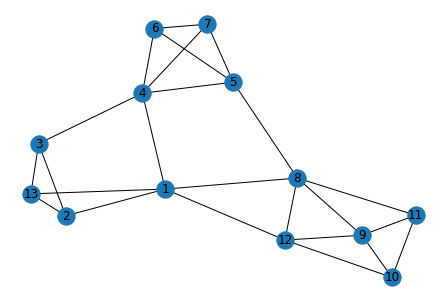

In [103]:
d = nx.Graph(G1)
nx.draw(d, with_labels=True)
plt.savefig('plotgraph.png', dpi=300, bbox_inches='tight')
plt.show()

In [104]:
grafo = recorridoDepth(G1, 1)
Spanning_Tree, Bactracking_Tree  = grafo.dFS()
print("Spanning Tree edges", Spanning_Tree)
#print("Bactracking Tree edges", Bactracking_Tree)

Spanning Tree edges [(1, 2), (2, 3), (3, 4), (3, 13), (4, 5), (5, 6), (5, 8), (6, 7), (8, 9), (9, 10), (10, 11), (10, 12)]


In [105]:
df = grafo.low1_low2()
df

,vertice,lowpt1,lowpt2
0,1,1,1
1,2,1,2
2,3,1,2
3,4,1,4
4,5,1,4
5,6,4,5
6,7,4,5
7,8,1,8
8,9,1,8
9,10,1,8


In [106]:
print(df.to_latex(index=False))

\begin{tabular}{lll}
\toprule
vertice & lowpt1 & lowpt2 \\
\midrule
      1 &      1 &      1 \\
      2 &      1 &      2 \\
      3 &      1 &      2 \\
      4 &      1 &      4 \\
      5 &      1 &      4 \\
      6 &      4 &      5 \\
      7 &      4 &      5 \\
      8 &      1 &      8 \\
      9 &      1 &      8 \\
     10 &      1 &      8 \\
     11 &      8 &      9 \\
     12 &      1 &      8 \\
     13 &      1 &      2 \\
\bottomrule
\end{tabular}



In [107]:
aux = auxTricconected(G1, 1)

In [108]:
aux.etiquetado()

({(1, 2): 5,
  (2, 3): 5,
  (3, 4): 5,
  (3, 13): 3,
  (4, 5): 5,
  (6, 7): 12,
  (5, 6): 14,
  (5, 8): 5,
  (9, 10): 3,
  (10, 11): 24,
  (10, 12): 3,
  (8, 9): 5},
 {(7, 4): 13,
  (7, 5): 16,
  (4, 1): 4,
  (6, 4): 13,
  (8, 1): 4,
  (11, 9): 28,
  (11, 8): 25,
  (12, 1): 4,
  (12, 9): 28,
  (12, 8): 25,
  (13, 1): 4,
  (13, 2): 7})

In [109]:
aristas_ordenadas = aux.ordenado()
print(aristas_ordenadas)

[(3, 13), (9, 10), (10, 12), (4, 1), (8, 1), (12, 1), (13, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 8), (8, 9), (13, 2), (6, 7), (7, 4), (6, 4), (5, 6), (7, 5), (10, 11), (11, 8), (12, 8), (11, 9), (12, 9)]


In [110]:
aux.ordenamientoDic()

{1: [2],
 2: [3],
 3: [13, 4],
 4: [1, 5],
 5: [8, 6],
 6: [7, 4],
 7: [4, 5],
 8: [1, 9],
 9: [10],
 10: [12, 11],
 11: [8, 9],
 12: [1, 8, 9],
 13: [1, 2]}

In [111]:
p = aux.pathfinder(1)
print(p)

path:  [(1, 2), (2, 3), (3, 13), (13, 1)]
path:  [(13, 2)]
path:  [(3, 4), (4, 1)]
path:  [(4, 5), (5, 8), (8, 1)]
path:  [(8, 9), (9, 10), (10, 12), (12, 1)]
path:  [(12, 8)]
path:  [(12, 9)]
path:  [(10, 11), (11, 8)]
path:  [(11, 9)]
path:  [(5, 6), (6, 7), (7, 4)]
path:  [(7, 5)]
path:  [(6, 4)]
[{1: [(1, 2), (2, 3), (3, 13), (13, 1)]}, {2: [(13, 2)]}, {3: [(3, 4), (4, 1)]}, {4: [(4, 5), (5, 8), (8, 1)]}, {5: [(8, 9), (9, 10), (10, 12), (12, 1)]}, {6: [(12, 8)]}, {7: [(12, 9)]}, {8: [(10, 11), (11, 8)]}, {9: [(11, 9)]}, {10: [(5, 6), (6, 7), (7, 4)]}, {11: [(7, 5)]}, {12: [(6, 4)]}]


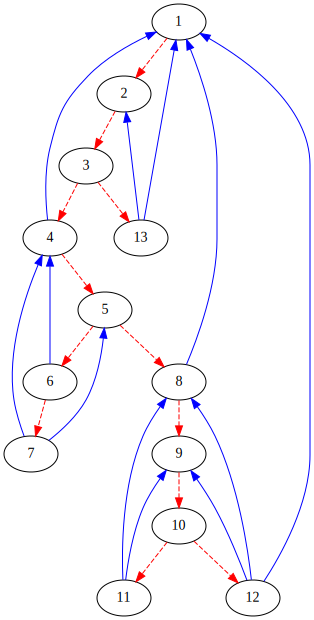

In [112]:
grafo.dibujar_grafo_recorrido('G2.png')

In [113]:
G = Graph(G1)

In [114]:
for u, v, l in G.edges():
	G.set_edge_label(u, v, f'({u},{v})')

In [115]:
tric1 = TriconnectivitySPQR_Aux(G)

In [116]:
print(tric1.comp_list_new1)

[[(8, 9, '(8,9)'), (9, 10, '(9,10)'), (10, 11, '(10,11)'), (9, 11, '(9,11)'), (8, 11, '(8,11)'), (10, 12, '(10,12)'), (9, 12, '(9,12)'), (8, 12, 'newVEdge0')], [(8, 12, '(8,12)'), (8, 12, 'newVEdge0'), (8, 12, 'newVEdge1')], [(8, 12, 'newVEdge1'), (1, 12, '(1,12)'), (8, 1, 'newVEdge2')], [(1, 8, '(1,8)'), (8, 1, 'newVEdge2'), (8, 1, 'newVEdge3')], [(5, 8, '(5,8)'), (8, 1, 'newVEdge3'), (5, 1, 'newVEdge4')], [(5, 6, '(5,6)'), (4, 6, '(4,6)'), (6, 7, '(6,7)'), (5, 7, '(5,7)'), (4, 7, '(4,7)'), (5, 4, 'newVEdge5')], [(5, 4, 'newVEdge5'), (4, 5, 'newVEdge6'), (4, 5, '(4,5)')], [(4, 5, 'newVEdge6'), (5, 1, 'newVEdge4'), (4, 1, 'newVEdge7')], [(1, 4, '(1,4)'), (4, 1, 'newVEdge7'), (4, 1, 'newVEdge8')], [(3, 4, '(3,4)'), (4, 1, 'newVEdge8'), (3, 1, 'newVEdge9')], [(1, 13, '(1,13)'), (2, 13, '(2,13)'), (3, 13, '(3,13)'), (3, 1, 'newVEdge9'), (2, 3, '(2,3)'), (1, 2, '(1,2)')]]


In [117]:
tric1.type1

[(1, 8), (1, 5), (4, 5), (1, 4), (1, 3)]

In [118]:
tric1.type2

[(8, 12)]

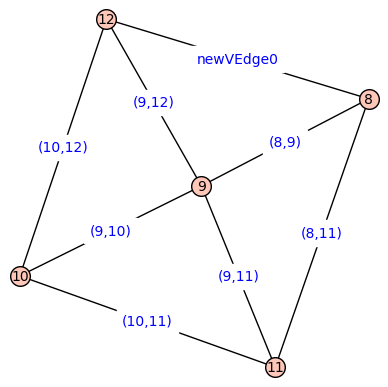

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$10$},x=5.0cm,y=0.5839cm]{v0}
\Vertex[L=\hbox{$11$},x=4.5561cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$12$},x=0.4061cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$8$},x=0.0cm,y=4.46cm]{v3}
\Vertex[L=\hbox{$9$},x=2.2914cm,y=2.5677cm]{v4}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v4)(v0)
\Edge[](v3)(v1)
\Edge[](v4)(v1)
\Edge[](v3)(v2)
\Edge[](v4)(v2)
\Edge[](v3)(v4)
%
\end{tikzpicture}


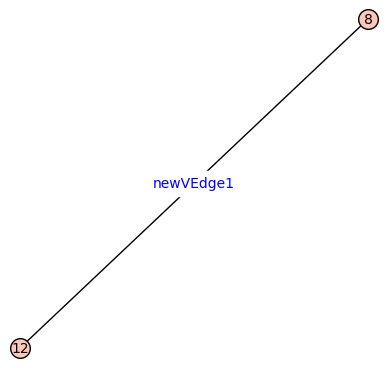

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$8$},x=5.0cm,y=0.0cm]{v1}
%
\Edge[](v1)(v0)
%
\end{tikzpicture}


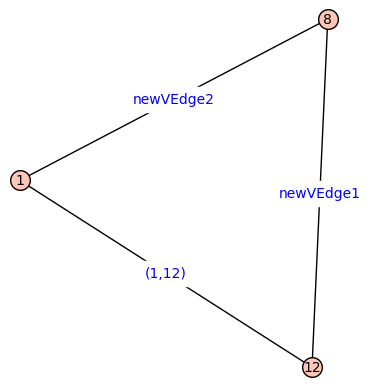

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$1$},x=0.4898cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$8$},x=5.0cm,y=2.6101cm]{v2}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v1)(v2)
%
\end{tikzpicture}


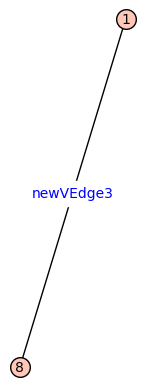

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$8$},x=5.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


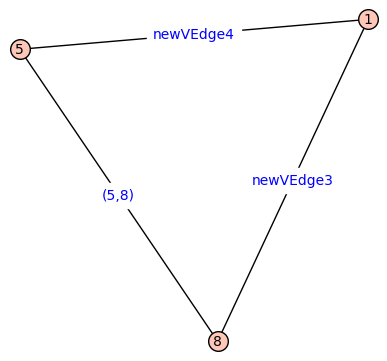

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=2.9008cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$5$},x=5.0cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$8$},x=0.0cm,y=4.4165cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


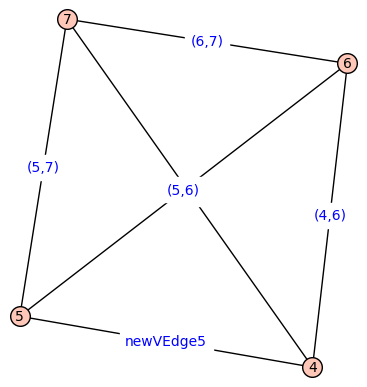

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=2.7219cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$5$},x=0.0cm,y=2.3675cm]{v1}
\Vertex[L=\hbox{$6$},x=5.0cm,y=2.6944cm]{v2}
\Vertex[L=\hbox{$7$},x=2.2537cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


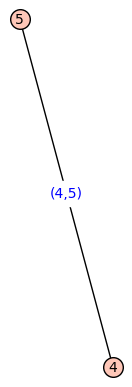

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$5$},x=5.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


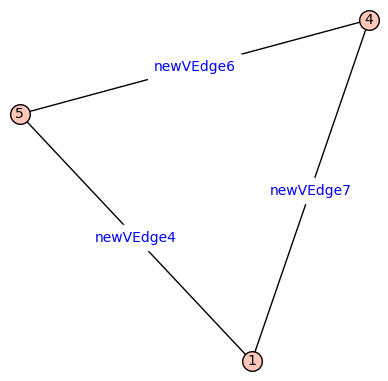

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=1.7518cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$5$},x=0.977cm,y=5.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


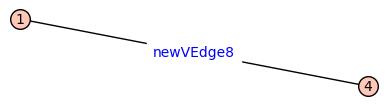

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


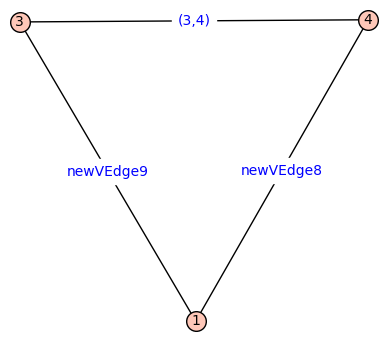

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=4.3223cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=0.0cm,y=1.9987cm]{v1}
\Vertex[L=\hbox{$4$},x=5.0cm,y=0.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


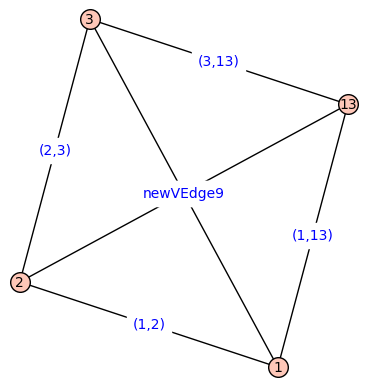

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$13$},x=0.0cm,y=3.9497cm]{v0}
\Vertex[L=\hbox{$1$},x=5.0cm,y=1.0149cm]{v1}
\Vertex[L=\hbox{$2$},x=0.9899cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$3$},x=4.0033cm,y=5.0cm]{v3}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v3)(v0)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


In [119]:
for componente in tric1.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#print(latex(grafo))

In [120]:
tric = TriconnectivitySPQR(G)
T = tric.get_spqr_tree()
G.is_isomorphic(spqr_tree_to_graph(T))

True

In [121]:
tric.print_triconnected_components()

Triconnected: [(5, 6, '(5,6)'), (4, 6, '(4,6)'), (6, 7, '(6,7)'), (5, 7, '(5,7)'), (4, 7, '(4,7)'), (5, 4, 'newVEdge0')]
Bond: [(5, 4, 'newVEdge0'), (4, 5, 'newVEdge1'), (4, 5, '(4,5)')]
Polygon: [(4, 5, 'newVEdge1'), (5, 8, '(5,8)'), (1, 4, 'newVEdge5'), (1, 8, 'newVEdge6')]
Triconnected: [(1, 2, '(1,2)'), (2, 3, '(2,3)'), (3, 13, '(3,13)'), (2, 13, '(2,13)'), (1, 13, '(1,13)'), (1, 3, 'newVEdge3')]
Polygon: [(1, 3, 'newVEdge3'), (3, 4, '(3,4)'), (1, 4, 'newVEdge4')]
Bond: [(1, 4, '(1,4)'), (1, 4, 'newVEdge4'), (1, 4, 'newVEdge5')]
Bond: [(1, 8, 'newVEdge6'), (8, 1, 'newVEdge7'), (1, 8, '(1,8)')]
Polygon: [(8, 1, 'newVEdge7'), (1, 12, '(1,12)'), (8, 12, 'newVEdge8')]
Bond: [(8, 12, '(8,12)'), (8, 12, 'newVEdge8'), (8, 12, 'newVEdge9')]
Triconnected: [(10, 12, '(10,12)'), (9, 12, '(9,12)'), (8, 12, 'newVEdge9'), (10, 11, '(10,11)'), (9, 11, '(9,11)'), (8, 11, '(8,11)'), (8, 9, '(8,9)'), (9, 10, '(9,10)')]


In [122]:
tric.get_triconnected_components()

[('Triconnected',
  [(5, 6, '(5,6)'),
   (4, 6, '(4,6)'),
   (6, 7, '(6,7)'),
   (5, 7, '(5,7)'),
   (4, 7, '(4,7)'),
   (5, 4, 'newVEdge0')]),
 ('Bond', [(5, 4, 'newVEdge0'), (4, 5, 'newVEdge1'), (4, 5, '(4,5)')]),
 ('Polygon',
  [(4, 5, 'newVEdge1'),
   (5, 8, '(5,8)'),
   (1, 4, 'newVEdge5'),
   (1, 8, 'newVEdge6')]),
 ('Triconnected',
  [(1, 2, '(1,2)'),
   (2, 3, '(2,3)'),
   (3, 13, '(3,13)'),
   (2, 13, '(2,13)'),
   (1, 13, '(1,13)'),
   (1, 3, 'newVEdge3')]),
 ('Polygon', [(1, 3, 'newVEdge3'), (3, 4, '(3,4)'), (1, 4, 'newVEdge4')]),
 ('Bond', [(1, 4, '(1,4)'), (1, 4, 'newVEdge4'), (1, 4, 'newVEdge5')]),
 ('Bond', [(1, 8, 'newVEdge6'), (8, 1, 'newVEdge7'), (1, 8, '(1,8)')]),
 ('Polygon', [(8, 1, 'newVEdge7'), (1, 12, '(1,12)'), (8, 12, 'newVEdge8')]),
 ('Bond', [(8, 12, '(8,12)'), (8, 12, 'newVEdge8'), (8, 12, 'newVEdge9')]),
 ('Triconnected',
  [(10, 12, '(10,12)'),
   (9, 12, '(9,12)'),
   (8, 12, 'newVEdge9'),
   (10, 11, '(10,11)'),
   (9, 11, '(9,11)'),
   (8, 11, '(8,11)'

In [123]:
componentes = tric.get_triconnected_components()

In [124]:
opts = G.latex_options()
G.set_latex_options(tkz_style='Art')

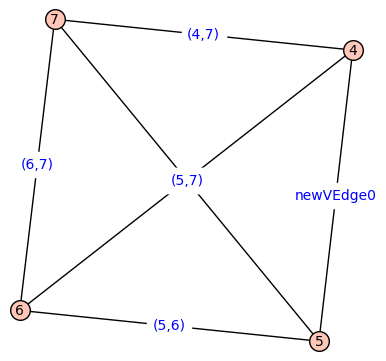

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=0.9956cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$5$},x=5.0cm,y=1.1265cm]{v1}
\Vertex[L=\hbox{$6$},x=0.0cm,y=3.8736cm]{v2}
\Vertex[L=\hbox{$7$},x=4.0039cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


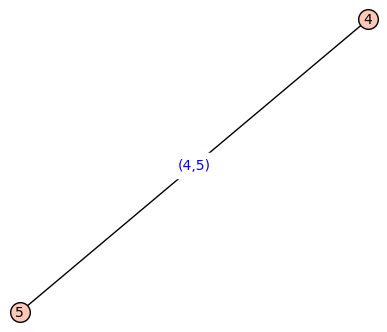

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$5$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


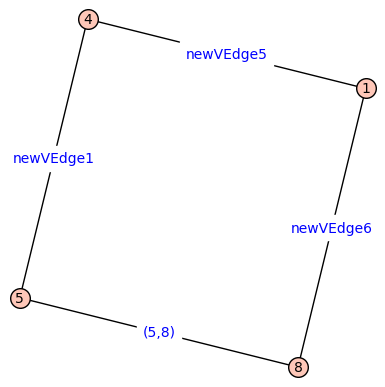

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=3.1699cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=3.0531cm]{v1}
\Vertex[L=\hbox{$5$},x=1.8301cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$8$},x=5.0cm,y=1.9469cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v2)(v3)
%
\end{tikzpicture}


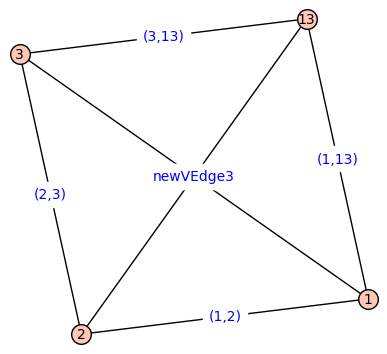

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$13$},x=3.7536cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$1$},x=0.0cm,y=1.2847cm]{v1}
\Vertex[L=\hbox{$2$},x=5.0cm,y=3.7153cm]{v2}
\Vertex[L=\hbox{$3$},x=1.2464cm,y=5.0cm]{v3}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v3)(v0)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


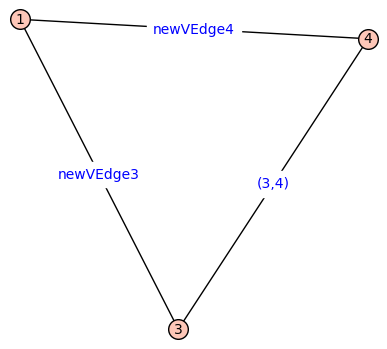

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=1.0351cm]{v0}
\Vertex[L=\hbox{$3$},x=5.0cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$4$},x=3.2883cm,y=5.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


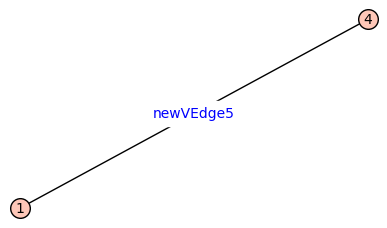

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


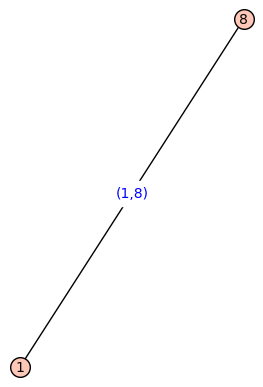

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$8$},x=5.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


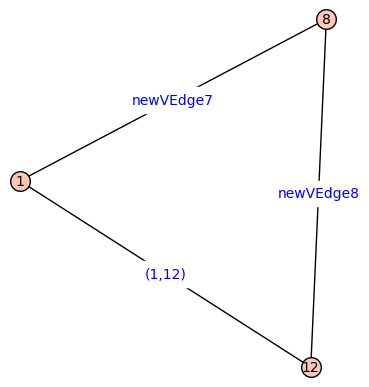

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$1$},x=5.0cm,y=4.5491cm]{v1}
\Vertex[L=\hbox{$8$},x=1.796cm,y=0.0cm]{v2}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v1)(v2)
%
\end{tikzpicture}


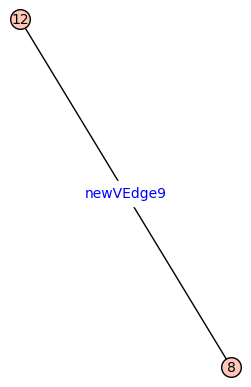

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$8$},x=5.0cm,y=0.0cm]{v1}
%
\Edge[](v1)(v0)
%
\end{tikzpicture}


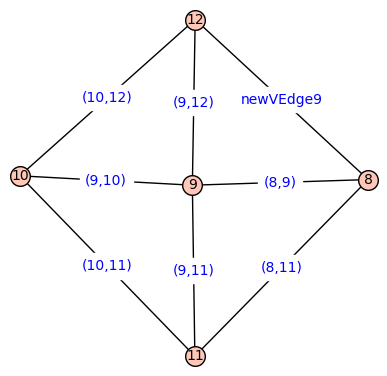

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$10$},x=5.0cm,y=2.4394cm]{v0}
\Vertex[L=\hbox{$12$},x=2.5265cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$11$},x=2.6116cm,y=5.0cm]{v2}
\Vertex[L=\hbox{$8$},x=0.0cm,y=2.5942cm]{v3}
\Vertex[L=\hbox{$9$},x=2.2653cm,y=2.4839cm]{v4}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v4)(v0)
\Edge[](v3)(v1)
\Edge[](v4)(v1)
\Edge[](v3)(v2)
\Edge[](v4)(v2)
\Edge[](v3)(v4)
%
\end{tikzpicture}


In [125]:
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#print(latex(grafo))

In [126]:
G2 = {
	1:[2, 4],
	2:[1, 3, 5, 6],
	3:[2, 4, 5, 6, 7],
	4:[1, 3, 7],
	5:[2, 3, 6],
	6:[2, 3, 5],
	7:[3, 4],
}

In [127]:
print(G2)

{1: [2, 4], 2: [1, 3, 5, 6], 3: [2, 4, 5, 6, 7], 4: [1, 3, 7], 5: [2, 3, 6], 6: [2, 3, 5], 7: [3, 4]}


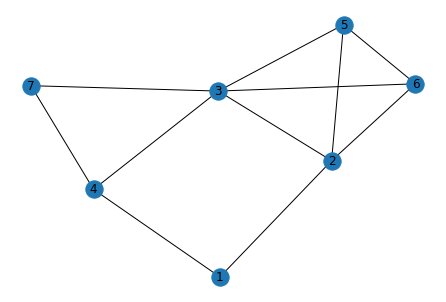

In [128]:
d = nx.Graph(G2)
nx.draw(d, with_labels=True)
plt.savefig('plotgraph1.png', dpi=300, bbox_inches='tight')
plt.show()

In [129]:
grafo = recorridoDepth(G2, 1)
Spanning_Tree, Bactracking_Tree = grafo.dFS()
print("Spanning Tree edges", Spanning_Tree)
#print("Bactracking Tree edges", Bactracking_Tree)

Spanning Tree edges [(1, 2), (2, 3), (3, 4), (3, 5), (4, 7), (5, 6)]


In [130]:
df = grafo.low1_low2()
df

,vertice,lowpt1,lowpt2
0,1,1,1
1,2,1,2
2,3,1,2
3,4,1,3
4,5,2,3
5,6,2,3
6,7,3,5


In [131]:
#print(df.to_latex(index=False))

In [132]:
aux = auxTricconected(G2, 1)
aux.etiquetado()

({(2, 3): 5, (3, 4): 5, (3, 5): 8, (1, 2): 5, (4, 7): 11, (5, 6): 6},
 {(4, 1): 4, (7, 3): 10, (6, 2): 7, (6, 3): 10, (5, 2): 7})

In [133]:
aristas_ordenadas = aux.ordenado()
print(aristas_ordenadas)

[(4, 1), (2, 3), (3, 4), (1, 2), (5, 6), (6, 2), (5, 2), (3, 5), (7, 3), (6, 3), (4, 7)]


In [134]:
aux.pathfinder(1)

path:  [(1, 2), (2, 3), (3, 4), (4, 1)]
path:  [(4, 7), (7, 3)]
path:  [(3, 5), (5, 6), (6, 2)]
path:  [(6, 3)]
path:  [(5, 2)]


[{1: [(1, 2), (2, 3), (3, 4), (4, 1)]},
 {2: [(4, 7), (7, 3)]},
 {3: [(3, 5), (5, 6), (6, 2)]},
 {4: [(6, 3)]},
 {5: [(5, 2)]}]

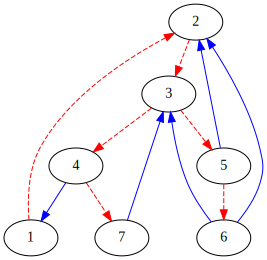

In [135]:
grafo.dibujar_grafo_recorrido('G3.png')

In [136]:
G12 = Graph(G2)

In [137]:
for u, v, l in G12.edges():
	G12.set_edge_label(u, v, f'({u},{v})')

In [138]:
tric12 = TriconnectivitySPQR_Aux(G12)
print(tric12.comp_list_new1)

[[(4, 7, '(4,7)'), (3, 7, '(3,7)'), (4, 3, 'newVEdge0')], [(4, 3, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, '(3,4)')], [(3, 4, 'newVEdge1'), (1, 4, '(1,4)'), (3, 1, 'newVEdge2')], [(3, 5, '(3,5)'), (2, 5, '(2,5)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (2, 6, '(2,6)'), (3, 2, 'newVEdge3')], [(3, 2, 'newVEdge3'), (2, 3, 'newVEdge4'), (2, 3, '(2,3)')], [(3, 1, 'newVEdge2'), (2, 3, 'newVEdge4'), (1, 2, '(1,2)')]]


In [139]:
tric12.type2

[]

In [140]:
tric12.type1

[(3, 4), (1, 3), (2, 3)]

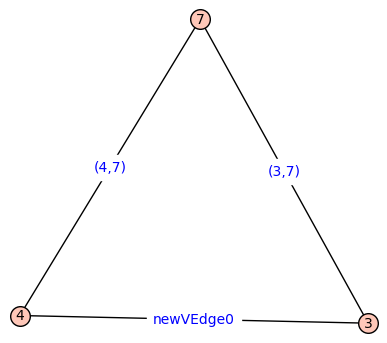

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=1.0579cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$7$},x=5.0cm,y=3.4218cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


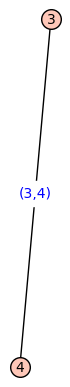

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


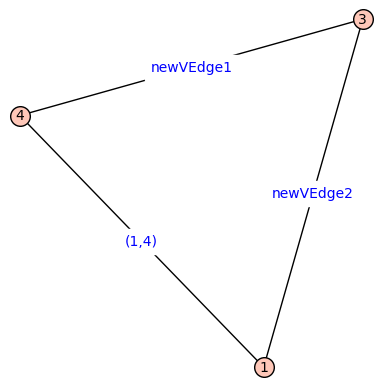

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=4.938cm]{v0}
\Vertex[L=\hbox{$3$},x=5.0cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$4$},x=2.5437cm,y=0.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


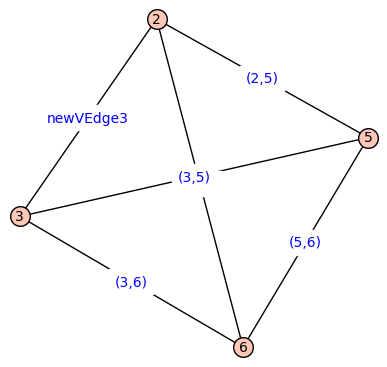

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=5.0cm,y=4.5343cm]{v0}
\Vertex[L=\hbox{$3$},x=0.5458cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$5$},x=0.0cm,y=0.4656cm]{v2}
\Vertex[L=\hbox{$6$},x=4.4541cm,y=0.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


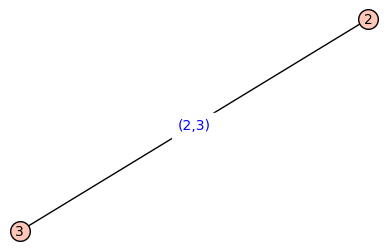

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=5.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


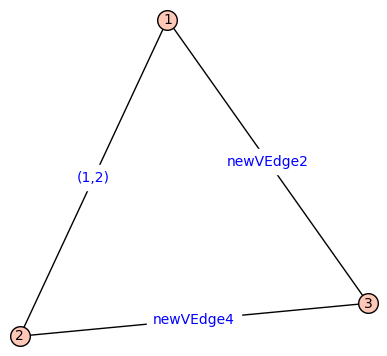

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$2$},x=5.0cm,y=0.1031cm]{v1}
\Vertex[L=\hbox{$3$},x=2.4279cm,y=5.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


In [141]:
for componente in tric12.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#check_tkz_graph()
	#print(latex(grafo))

In [142]:
tric = TriconnectivitySPQR(G12)
T = tric.get_spqr_tree()
G12.is_isomorphic(spqr_tree_to_graph(T))

True

In [143]:
tric.print_triconnected_components()

Polygon: [(4, 7, '(4,7)'), (3, 7, '(3,7)'), (4, 3, 'newVEdge0')]
Bond: [(4, 3, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, '(3,4)')]
Polygon: [(3, 4, 'newVEdge1'), (1, 4, '(1,4)'), (2, 3, 'newVEdge4'), (1, 2, '(1,2)')]
Triconnected: [(3, 5, '(3,5)'), (2, 5, '(2,5)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (2, 6, '(2,6)'), (3, 2, 'newVEdge3')]
Bond: [(3, 2, 'newVEdge3'), (2, 3, 'newVEdge4'), (2, 3, '(2,3)')]


In [144]:
tric.get_triconnected_components()

[('Polygon', [(4, 7, '(4,7)'), (3, 7, '(3,7)'), (4, 3, 'newVEdge0')]),
 ('Bond', [(4, 3, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, '(3,4)')]),
 ('Polygon',
  [(3, 4, 'newVEdge1'),
   (1, 4, '(1,4)'),
   (2, 3, 'newVEdge4'),
   (1, 2, '(1,2)')]),
 ('Triconnected',
  [(3, 5, '(3,5)'),
   (2, 5, '(2,5)'),
   (5, 6, '(5,6)'),
   (3, 6, '(3,6)'),
   (2, 6, '(2,6)'),
   (3, 2, 'newVEdge3')]),
 ('Bond', [(3, 2, 'newVEdge3'), (2, 3, 'newVEdge4'), (2, 3, '(2,3)')])]

In [145]:
componentes = tric.get_triconnected_components()

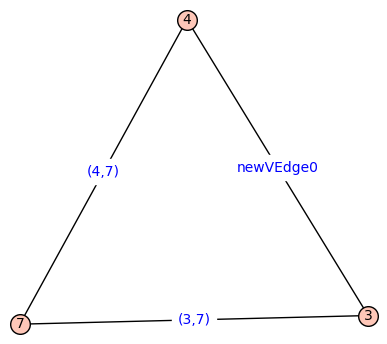

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=0.0cm,y=3.2177cm]{v0}
\Vertex[L=\hbox{$4$},x=5.0cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$7$},x=4.473cm,y=0.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


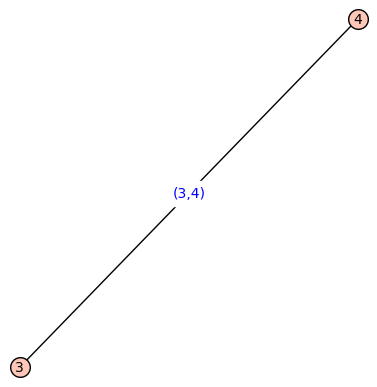

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=5.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


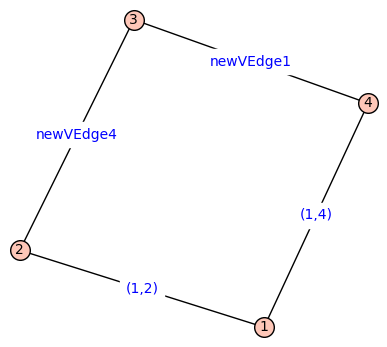

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=1.5826cm]{v0}
\Vertex[L=\hbox{$2$},x=3.1544cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$3$},x=0.0cm,y=3.2086cm]{v2}
\Vertex[L=\hbox{$4$},x=1.6822cm,y=0.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v2)(v3)
%
\end{tikzpicture}


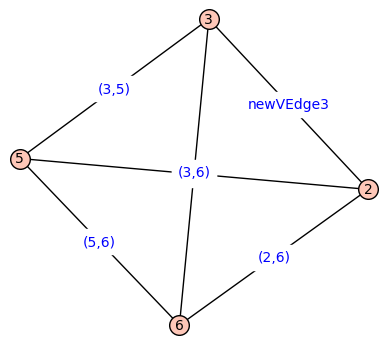

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=0.0cm,y=0.0484cm]{v1}
\Vertex[L=\hbox{$5$},x=4.3561cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$6$},x=0.6834cm,y=4.9946cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


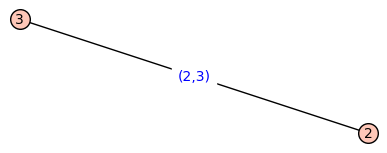

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=5.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


In [146]:
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#check_tkz_graph()
	#print(latex(grafo))

In [147]:
G3 = {
	1: [2, 3, 4],
	2: [1, 3, 4],
	3: [1, 2, 5, 6],
	4: [1, 2, 5, 6],
	5: [3, 4, 6],
	6: [3, 4, 5]
}
print(G3)

{1: [2, 3, 4], 2: [1, 3, 4], 3: [1, 2, 5, 6], 4: [1, 2, 5, 6], 5: [3, 4, 6], 6: [3, 4, 5]}


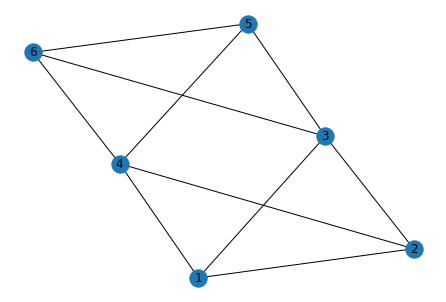

In [148]:
d = nx.Graph(G3)
nx.draw(d, with_labels=True)
plt.savefig('plotgraph2.png', dpi=300, bbox_inches='tight')
plt.show()

In [149]:
grafo = recorridoDepth(G3, 1)
Spanning_Tree, Bactracking_Tree = grafo.dFS()
print("Spanning Tree edges", Spanning_Tree)
#print("Bactracking Tree edges", Bactracking_Tree)

Spanning Tree edges [(1, 2), (2, 3), (3, 5), (4, 6), (5, 4)]


In [150]:
df = grafo.low1_low2()
df

,vertice,lowpt1,lowpt2
0,1,1,1
1,2,1,2
2,3,1,2
3,4,1,2
4,5,1,2
5,6,3,4


In [151]:
#print(df.to_latex(index=False))

In [152]:
aux = auxTricconected(G3, 1)
aux.etiquetado()

({(1, 2): 5, (2, 3): 5, (5, 4): 3, (4, 6): 11, (3, 5): 3},
 {(6, 5): 16, (6, 3): 10, (3, 1): 4, (4, 2): 7, (4, 1): 4})

In [153]:
aristas_ordenadas = aux.ordenado()
print(aristas_ordenadas)

[(5, 4), (3, 5), (3, 1), (4, 1), (1, 2), (2, 3), (4, 2), (6, 3), (4, 6), (6, 5)]


In [154]:
aux.pathfinder(1)

path:  [(1, 2), (2, 3), (3, 5), (5, 4), (4, 1)]
path:  [(4, 2)]
path:  [(4, 6), (6, 3)]
path:  [(6, 5)]
path:  [(3, 1)]


[{1: [(1, 2), (2, 3), (3, 5), (5, 4), (4, 1)]},
 {2: [(4, 2)]},
 {3: [(4, 6), (6, 3)]},
 {4: [(6, 5)]},
 {5: [(3, 1)]}]

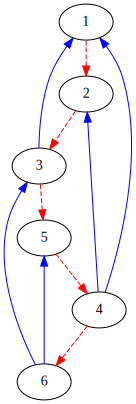

In [155]:
grafo.dibujar_grafo_recorrido('G4.png')

In [156]:
G22 = Graph(G3)

In [157]:
for u, v, l in G22.edges():
	G22.set_edge_label(u, v, f'({u},{v})')

In [158]:
tric22 = TriconnectivitySPQR_Aux(G22)
print(len(tric22.comp_list_new1))
print(tric22.comp_list_new1)

2
[[(3, 5, '(3,5)'), (4, 5, '(4,5)'), (4, 6, '(4,6)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (3, 4, 'newVEdge0')], [(1, 4, '(1,4)'), (2, 4, '(2,4)'), (3, 4, 'newVEdge0'), (1, 3, '(1,3)'), (2, 3, '(2,3)'), (1, 2, '(1,2)')]]


In [159]:
tric22.type1

[]

In [160]:
tric22.type2

[(3, 4)]

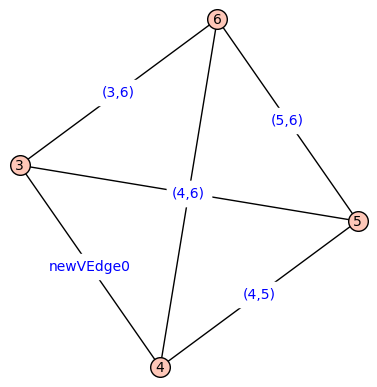

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=5.0cm,y=0.8172cm]{v0}
\Vertex[L=\hbox{$4$},x=4.2299cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$5$},x=0.7694cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$6$},x=0.0cm,y=4.1851cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


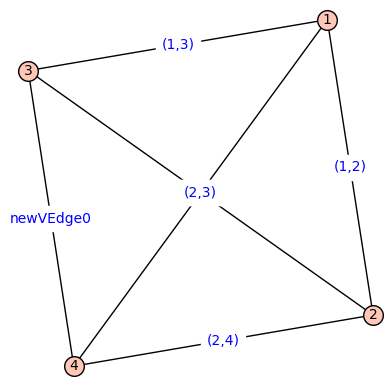

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=4.3881cm]{v0}
\Vertex[L=\hbox{$2$},x=5.0cm,y=0.6126cm]{v1}
\Vertex[L=\hbox{$3$},x=0.5821cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$4$},x=4.4188cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


In [161]:
for componente in tric22.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
#check_tkz_graph()
#print(latex(grafo))

In [162]:
tric = TriconnectivitySPQR(G22)
T = tric.get_spqr_tree()
G22.is_isomorphic(spqr_tree_to_graph(T))

True

In [163]:
tric.print_triconnected_components()

Triconnected: [(3, 5, '(3,5)'), (4, 5, '(4,5)'), (4, 6, '(4,6)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (3, 4, 'newVEdge0')]
Triconnected: [(1, 4, '(1,4)'), (2, 4, '(2,4)'), (3, 4, 'newVEdge0'), (1, 3, '(1,3)'), (2, 3, '(2,3)'), (1, 2, '(1,2)')]


In [164]:
tric.get_triconnected_components()

[('Triconnected',
  [(3, 5, '(3,5)'),
   (4, 5, '(4,5)'),
   (4, 6, '(4,6)'),
   (5, 6, '(5,6)'),
   (3, 6, '(3,6)'),
   (3, 4, 'newVEdge0')]),
 ('Triconnected',
  [(1, 4, '(1,4)'),
   (2, 4, '(2,4)'),
   (3, 4, 'newVEdge0'),
   (1, 3, '(1,3)'),
   (2, 3, '(2,3)'),
   (1, 2, '(1,2)')])]

In [165]:
componentes = tric.get_triconnected_components()

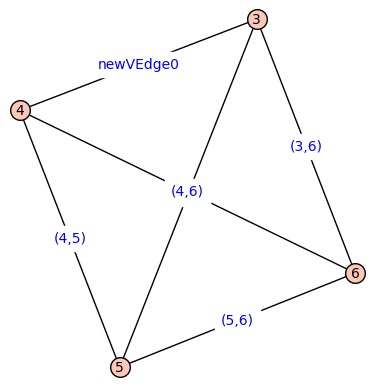

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=0.0cm,y=0.4768cm]{v0}
\Vertex[L=\hbox{$4$},x=5.0cm,y=4.5393cm]{v1}
\Vertex[L=\hbox{$5$},x=4.3275cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$6$},x=0.6535cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


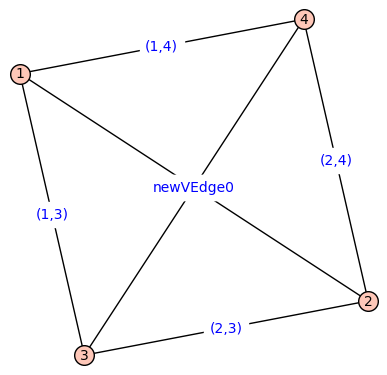

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=3.5874cm]{v0}
\Vertex[L=\hbox{$2$},x=0.0cm,y=1.2088cm]{v1}
\Vertex[L=\hbox{$3$},x=1.2514cm,y=5.0cm]{v2}
\Vertex[L=\hbox{$4$},x=3.7867cm,y=0.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


In [166]:
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#check_tkz_graph()
	#print(latex(grafo))

In [167]:
G4 = {
	1: [3, 4, 5],
	2: [3, 4, 5],
	3: [1, 2],
	4: [1, 2, 5],
	5: [2, 1, 4]
}
print(G4)

{1: [3, 4, 5], 2: [3, 4, 5], 3: [1, 2], 4: [1, 2, 5], 5: [2, 1, 4]}


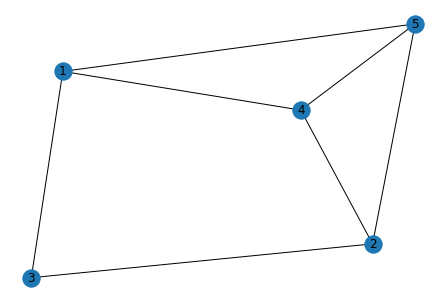

In [168]:
d = nx.Graph(G4)
nx.draw(d, with_labels=True)
plt.savefig('plotgraph3.png', dpi=300, bbox_inches='tight')
plt.show()

In [169]:
grafo = recorridoDepth(G4, 1)
Spanning_Tree, Bactracking_Tree = grafo.dFS()
print("Spanning Tree edges", Spanning_Tree)
#print("Bactracking Tree edges", Bactracking_Tree)

Spanning Tree edges [(1, 3), (2, 4), (3, 2), (4, 5)]


In [170]:
df = grafo.low1_low2()
df

,vertice,lowpt1,lowpt2
0,1,1,1
1,2,1,3
2,3,1,2
3,4,1,3
4,5,1,3


In [171]:
#print(df.to_latex(index=False))

In [172]:
aux = auxTricconected(G4, 1)
aux.etiquetado()

({(4, 5): 3, (3, 2): 5, (2, 4): 5, (1, 3): 5},
 {(4, 1): 4, (5, 1): 4, (5, 2): 7})

In [173]:
aristas_ordenadas = aux.ordenado()
print(aristas_ordenadas)

[(4, 5), (4, 1), (5, 1), (3, 2), (2, 4), (1, 3), (5, 2)]


In [174]:
aux.pathfinder(1)

path:  [(1, 3), (3, 2), (2, 4), (4, 5), (5, 1)]
path:  [(5, 2)]
path:  [(4, 1)]


[{1: [(1, 3), (3, 2), (2, 4), (4, 5), (5, 1)]}, {2: [(5, 2)]}, {3: [(4, 1)]}]

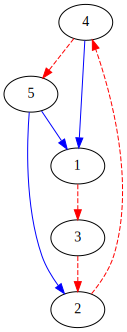

In [175]:
grafo.dibujar_grafo_recorrido('G5.png')

In [176]:
G32 = Graph(G4)
for u, v, l in G32.edges():
	G32.set_edge_label(u, v, f'({u},{v})')

In [177]:
tric32 = TriconnectivitySPQR_Aux(G32)
print(len(tric32.comp_list_new1))
print(tric32.comp_list_new1)

2
[[(2, 4, '(2,4)'), (1, 4, '(1,4)'), (4, 5, '(4,5)'), (2, 5, '(2,5)'), (1, 5, '(1,5)'), (2, 1, 'newVEdge0')], [(2, 1, 'newVEdge0'), (2, 3, '(2,3)'), (1, 3, '(1,3)')]]


In [178]:
tric32.type1

[(1, 2)]

In [179]:
tric32.type2

[]

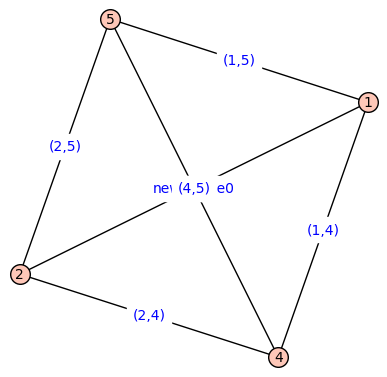

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.5003cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$2$},x=5.0cm,y=0.4554cm]{v1}
\Vertex[L=\hbox{$4$},x=0.0cm,y=4.5446cm]{v2}
\Vertex[L=\hbox{$5$},x=4.4997cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


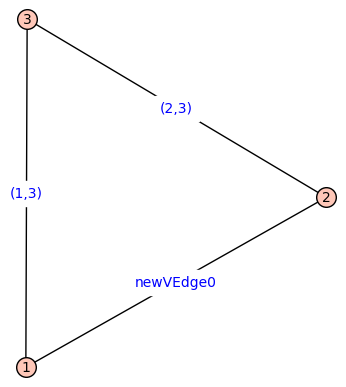

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$2$},x=5.0cm,y=0.7423cm]{v1}
\Vertex[L=\hbox{$3$},x=1.8346cm,y=5.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


In [180]:
for componente in tric32.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
#check_tkz_graph()
#print(latex(grafo))

In [181]:
tric = TriconnectivitySPQR(G32)
T = tric.get_spqr_tree()
G22.is_isomorphic(spqr_tree_to_graph(T))

False

In [182]:
tric.print_triconnected_components()

Triconnected: [(2, 4, '(2,4)'), (1, 4, '(1,4)'), (4, 5, '(4,5)'), (2, 5, '(2,5)'), (1, 5, '(1,5)'), (2, 1, 'newVEdge0')]
Polygon: [(2, 1, 'newVEdge0'), (2, 3, '(2,3)'), (1, 3, '(1,3)')]


In [183]:
tric.get_triconnected_components()

[('Triconnected',
  [(2, 4, '(2,4)'),
   (1, 4, '(1,4)'),
   (4, 5, '(4,5)'),
   (2, 5, '(2,5)'),
   (1, 5, '(1,5)'),
   (2, 1, 'newVEdge0')]),
 ('Polygon', [(2, 1, 'newVEdge0'), (2, 3, '(2,3)'), (1, 3, '(1,3)')])]

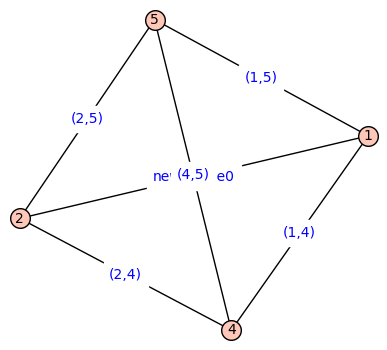

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=2.8169cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$2$},x=2.1797cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$4$},x=5.0cm,y=2.9681cm]{v2}
\Vertex[L=\hbox{$5$},x=0.0cm,y=2.0363cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


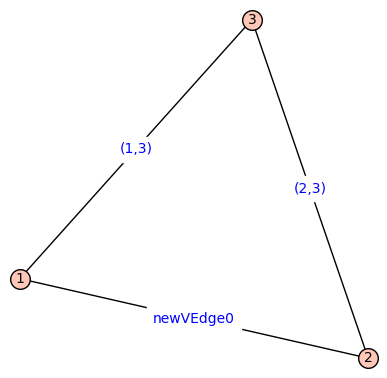

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=3.5368cm]{v0}
\Vertex[L=\hbox{$2$},x=0.0cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$3$},x=1.331cm,y=0.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


In [184]:
componentes = tric.get_triconnected_components()
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
#check_tkz_graph()
#print(latex(grafo))